In [1]:
import pandas as pd
import os

DATA_PATH = "datasets"

mental_subs = {
    "depression": "Depression",
    "anxiety": "Anxiety",
    "bpd": "BPD",
    "suicidewatch": "SuicideWatch"
}

control_subs = ["jokes", "personalfinance", "parenting", "fitness"]

def load_subreddit(subreddit, label_name):
    df_2018 = pd.read_csv(os.path.join(DATA_PATH, f"{subreddit}_2018_features_tfidf_256.csv"))
    df_2019 = pd.read_csv(os.path.join(DATA_PATH, f"{subreddit}_2019_features_tfidf_256.csv"))
    
    df = pd.concat([df_2018, df_2019], ignore_index=True)
    df = df[["subreddit", "post"]].copy()
    df["label"] = label_name
    
    return df

dfs = []

# Load mental health
for sub, label in mental_subs.items():
    dfs.append(load_subreddit(sub, label))

# Load control
for sub in control_subs:
    dfs.append(load_subreddit(sub, "Control"))

full_df = pd.concat(dfs, ignore_index=True)

print("Total samples:", len(full_df))
print("\nClass distribution:")
print(full_df["label"].value_counts())


Total samples: 254901

Class distribution:
label
Control         142892
Depression       58089
SuicideWatch     24807
Anxiety          21799
BPD               7314
Name: count, dtype: int64


In [2]:
# Remove NaNs
full_df = full_df.dropna(subset=["post"])

# Remove extremely short posts (< 10 words)
full_df["word_count"] = full_df["post"].apply(lambda x: len(str(x).split()))
full_df = full_df[full_df["word_count"] >= 10]

print("After cleaning:")
print(full_df["label"].value_counts())

After cleaning:
label
Control         140209
Depression       57925
SuicideWatch     24660
Anxiety          21778
BPD               7298
Name: count, dtype: int64


In [3]:
# Check class counts first
print("Before balancing:")
print(full_df["label"].value_counts())

# Find smallest class size
min_samples = full_df["label"].value_counts().min()

# Manual balancing (more stable than groupby.apply)
balanced_dfs = []

for label in full_df["label"].unique():
    subset = full_df[full_df["label"] == label]
    subset_sampled = subset.sample(min_samples, random_state=42)
    balanced_dfs.append(subset_sampled)

balanced_df = pd.concat(balanced_dfs).reset_index(drop=True)

print("\nAfter balancing:")
print(balanced_df["label"].value_counts())

Before balancing:
label
Control         140209
Depression       57925
SuicideWatch     24660
Anxiety          21778
BPD               7298
Name: count, dtype: int64

After balancing:
label
Depression      7298
Anxiety         7298
BPD             7298
SuicideWatch    7298
Control         7298
Name: count, dtype: int64


In [4]:
print("\nAverage word count per class:")
print(balanced_df.groupby("label")["word_count"].mean())

print("\nOverall average word count:")
print(balanced_df["word_count"].mean())


Average word count per class:
label
Anxiety         181.587284
BPD             192.040011
Control         129.905591
Depression      190.556180
SuicideWatch    187.617566
Name: word_count, dtype: float64

Overall average word count:
176.341326390792


In [5]:
balanced_df = balanced_df[["post", "label"]]
balanced_df.to_csv("reddit_mental_health.csv", index=False)

In [6]:
from sklearn.model_selection import train_test_split

X = balanced_df["post"]
y = balanced_df["label"]

X_train, X_test, y_train, y_test = train_test_split(
    X, y, 
    test_size=0.2, 
    random_state=42, 
    stratify=y
)

print("Training samples:", len(X_train))
print("Testing samples:", len(X_test))

Training samples: 29192
Testing samples: 7298


In [7]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix

# Convert text to TF-IDF features
vectorizer = TfidfVectorizer(
    max_features=10000,
    stop_words="english"
)

X_train_tfidf = vectorizer.fit_transform(X_train)
X_test_tfidf = vectorizer.transform(X_test)

# Train model
model = LogisticRegression(max_iter=1000)
model.fit(X_train_tfidf, y_train)

# Predict
y_pred = model.predict(X_test_tfidf)

# Evaluation
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

     Anxiety       0.85      0.81      0.83      1460
         BPD       0.84      0.76      0.80      1459
     Control       0.87      0.97      0.92      1460
  Depression       0.61      0.62      0.61      1460
SuicideWatch       0.70      0.70      0.70      1459

    accuracy                           0.77      7298
   macro avg       0.77      0.77      0.77      7298
weighted avg       0.77      0.77      0.77      7298



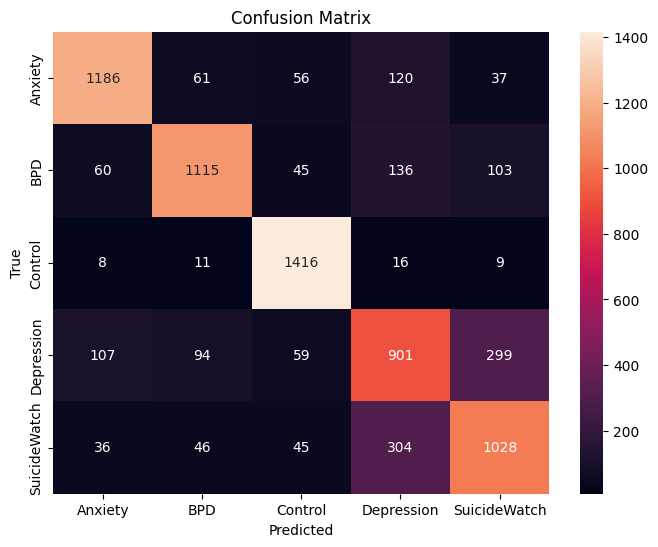

In [8]:
import seaborn as sns
import matplotlib.pyplot as plt

cm = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt="d",
            xticklabels=model.classes_,
            yticklabels=model.classes_)
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix")
plt.show()

In [9]:
import numpy as np

feature_names = np.array(vectorizer.get_feature_names_out())

In [10]:
# Get model coefficients
coefficients = model.coef_

# For each class
for i, class_label in enumerate(model.classes_):
    
    top10 = np.argsort(coefficients[i])[-15:]  # top 15 words
    
    print(f"\nTop words for class: {class_label}")
    print(feature_names[top10])


Top words for class: Anxiety
['stomach' 'scared' 'worrying' 'freaking' 'overthinking' 'terrified'
 'panicking' 'fear' 'attack' 'worry' 'nervous' 'gad' 'panic' 'anxious'
 'anxiety']

Top words for class: BPD
['identity' 'boyfriend' 'mood' 'abandoned' 'abandonment' 'rage' 'emotions'
 'borderline' 'splitting' 'diagnosis' 'diagnosed' 'dae' 'dbt' 'fp' 'bpd']

Top words for class: Control
['man' 'lifting' 'gym' 'fitness' 'wife' 'taxes' 'tax' 'pay' 'old'
 'workout' 'baby' 'credit' 'son' 'kids' 'daughter']

Top words for class: Depression
['effexor' 'just' 'happiness' 'friends' 'happy' 'antidepressants'
 'sadness' 'bed' 'feel' 'sad' 'motivation' 'life' 'depressive' 'depressed'
 'depression']

Top words for class: SuicideWatch
['tried' 'tonight' 'ending' 'pills' 'anymore' 'killing' 'gun' 'goodbye'
 'overdose' 'end' 'life' 'die' 'kill' 'suicidal' 'suicide']


In [15]:
top_words_dict = {}

for i, class_label in enumerate(model.classes_):
    top_indices = np.argsort(coefficients[i])[-100:]
    top_words = set(feature_names[top_indices])
    top_words_dict[class_label] = top_words

# View dictionary
for k, v in top_words_dict.items():
    print(f"\n{k}:")
    print(v)


Anxiety:
{'paxil', 'lexapro', 'nervous', 'seriously', 'worry', 'conversations', 'work', 'shaking', 'afraid', 'overthinking', 'stressful', 'celexa', 'situations', 'fear', 'heart', 'like', 'panic', 'store', 'symptoms', 'semester', 'podcast', 'scared', 'headaches', 'relaxing', 'brain', 'event', 'flight', 'dose', 'dizzy', 'feeling', 'gad', 'stomach', 'conscious', 'asleep', 'anxieties', 'paranoid', 'doctor', 'chest', 'xanax', 'helps', 'awkward', 'anxious', 'tips', 'think', 'calm', 'breathe', 'movies', 'stressing', 'relax', 'uncomfortable', 'presentation', 'worrying', 'embarrassed', 'thinking', 'driving', 'weekend', 'racing', 'does', 'having', 'breath', 'hands', 'worried', 'ocd', 'irrational', 'weird', 'panicking', 'confidence', 'zoloft', 'intrusive', 'focus', 'sweating', 'interview', 'eye', 'problem', 'flying', 'today', 'events', 'anxiety', 'medication', 'class', 'ssri', 'weighted', 'terrified', 'attacks', 'related', 'gonna', 'proud', 'freaking', 'fears', 'small', 'attack', 'stressed', 'fe

In [16]:
import pandas as pd

classes = list(top_words_dict.keys())

overlap_matrix = pd.DataFrame(index=classes, columns=classes)

for class1 in classes:
    for class2 in classes:
        set1 = top_words_dict[class1]
        set2 = top_words_dict[class2]
        
        intersection = len(set1.intersection(set2))
        union = len(set1.union(set2))
        
        jaccard = intersection / union
        
        overlap_matrix.loc[class1, class2] = round(jaccard, 3)

overlap_matrix

,Anxiety,BPD,Control,Depression,SuicideWatch
Anxiety,1.0,0.026,0.0,0.01,0.005
BPD,0.026,1.0,0.0,0.005,0.0
Control,0.0,0.0,1.0,0.0,0.005
Depression,0.01,0.005,0.0,1.0,0.093
SuicideWatch,0.005,0.0,0.005,0.093,1.0


In [17]:
from sklearn.svm import LinearSVC
from sklearn.metrics import classification_report, confusion_matrix

# Train SVM
svm_model = LinearSVC()
svm_model.fit(X_train_tfidf, y_train)

# Predict
y_pred_svm = svm_model.predict(X_test_tfidf)

# Evaluation
print("Linear SVM Results:\n")
print(classification_report(y_test, y_pred_svm))

Linear SVM Results:

              precision    recall  f1-score   support

     Anxiety       0.82      0.82      0.82      1460
         BPD       0.83      0.76      0.80      1459
     Control       0.90      0.96      0.93      1460
  Depression       0.59      0.58      0.58      1460
SuicideWatch       0.67      0.69      0.68      1459

    accuracy                           0.76      7298
   macro avg       0.76      0.76      0.76      7298
weighted avg       0.76      0.76      0.76      7298



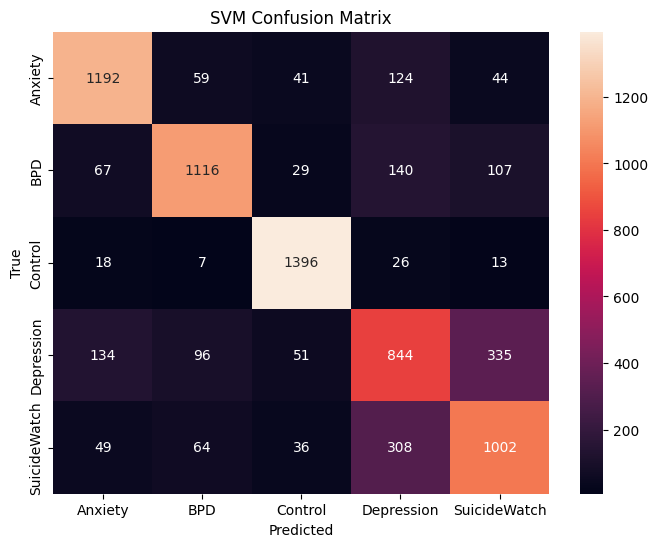

In [18]:
import seaborn as sns
import matplotlib.pyplot as plt

cm_svm = confusion_matrix(y_test, y_pred_svm)

plt.figure(figsize=(8,6))
sns.heatmap(cm_svm, annot=True, fmt="d",
            xticklabels=svm_model.classes_,
            yticklabels=svm_model.classes_)
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("SVM Confusion Matrix")
plt.show()